# Policy Gradient

This code is an example using Policy Gradient Method. The code is from [this website](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63).
The example uses the gym [CartPole system](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

In [4]:
import sys
import gym
import numpy as np  

import torch  
import torch.nn            as nn
import torch.optim         as optim
import torch.nn.functional as F
import matplotlib.pyplot   as plt

from   torch.autograd import Variable



# Defining a Policy Network

The policy neural network has three layers, with (layer1, $l_1$) n_s x (layer2, $l_2$) $n_{hidden}$ x (layer3, $l_3$) $n_a$. \
From $l_1$ to $l_2$ and $l_2$ to $l_3$, the network uses a linear combination, i.e., using $l_1$, $l_2$ and $l_3$ as an array of values of the corresponding neurons:
$$
\begin{align*}
    l_2 &= W_{12} \cdot l_1 + b_{12} \\
    l_3 &= W_{23} \cdot l_2 + b_{23}
\end{align*}    
$$
Note that the values are not directly used, but feed into a nonlinear function.
$l_2$ is feed into a ReLU (Rectified Linear Unit) function, and $l_3$ is fed into a softmax function to make it as a probability distribution function (i.e., all the values are non-negative and it sums to 1)

In [6]:

class PolicyNetwork( nn.Module ):
    def __init__( self, num_inputs, num_actions, hidden_size, learning_rate = 3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1     = nn.Linear( num_inputs, hidden_size  )
        self.linear2     = nn.Linear( hidden_size, num_actions )
        self.optimizer   = optim.Adam( self.parameters(), lr = learning_rate )

    def forward(self, state):
        x = F.relu( self.linear1( state ) )
        x = F.softmax( self.linear2( x ), dim=1)
        return x 
    
    def get_action( self, state ):
        state = torch.from_numpy( state ).float().unsqueeze( 0 )

        # Forward the neural network and return the prbability distribution function
        probs = self.forward( Variable( state ) )

        # Choosing the action based on the output policy
        highest_prob_action = np.random.choice( self.num_actions, p = np.squeeze( probs.detach( ).numpy( ) ) )

        # The log-value of the probability just for the sake of policy gradient
        log_prob            = torch.log( probs.squeeze( 0 )[ highest_prob_action ] )
        return highest_prob_action, log_prob


# Policy update via Gradient

The policy gradient formula is as follows:
$$
    \Delta_\theta J(\theta) = \sum_{t=0}^{T-1} \Delta_{\theta} \log \pi_{\theta} (a_t | s_t) G_t
$$
where $G_t$ is a discounted reward:
$$
    G_t = \mathbb{E}[R_{t+1}+\gamma R_{t+2}+\cdots | S_t = s]
$$
This method is called the REINFORCE algorithm, which is a Monte-Carlo variant of policy gradients. Note that Monte-Carlo methods is simply a hard way of saying "methods using random samples".

In [7]:

def update_policy( policy_network, rewards, log_probs ):

    # Constants
    GAMMA = 0.9

    discounted_rewards = [ ]

    # Given the trajectory (or arrays) of rewards, we calculate the discounted reward. 
    for t in range( len( rewards ) ) :
        Gt = 0 
        pw = 0
        for r in rewards[ t: ] :
            Gt = Gt + GAMMA ** pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor( discounted_rewards )
    discounted_rewards = ( discounted_rewards - discounted_rewards.mean( ) ) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    # [REF] https://datascience.stackexchange.com/questions/20098/why-do-we-normalize-the-discounted-rewards-when-doing-policy-gradient-reinforcem

    policy_gradient = [ ]

    for log_prob, Gt in zip( log_probs, discounted_rewards ):
        policy_gradient.append(-log_prob * Gt)
    
    # Initialization of the gradient value
    policy_network.optimizer.zero_grad( )
    
    policy_gradient = torch.stack( policy_gradient ).sum( )

    # Backpropagation (or simply, chain rule!)
    policy_gradient.backward( )
    policy_network.optimizer.step()        



# Example - Cart-and-Pole System

The 

episode: 0, total reward: 35.0, average_reward: 35.0, length: 34
episode: 1, total reward: 13.0, average_reward: 24.0, length: 12
episode: 2, total reward: 26.0, average_reward: 24.667, length: 25
episode: 3, total reward: 13.0, average_reward: 21.75, length: 12
episode: 4, total reward: 11.0, average_reward: 19.6, length: 10
episode: 5, total reward: 13.0, average_reward: 18.5, length: 12
episode: 6, total reward: 25.0, average_reward: 19.429, length: 24
episode: 7, total reward: 16.0, average_reward: 19.0, length: 15
episode: 8, total reward: 14.0, average_reward: 18.444, length: 13
episode: 9, total reward: 18.0, average_reward: 18.4, length: 17
episode: 10, total reward: 40.0, average_reward: 18.9, length: 39
episode: 11, total reward: 13.0, average_reward: 18.9, length: 12
episode: 12, total reward: 14.0, average_reward: 17.7, length: 13
episode: 13, total reward: 13.0, average_reward: 17.7, length: 12
episode: 14, total reward: 24.0, average_reward: 19.0, length: 23
episode: 15, 

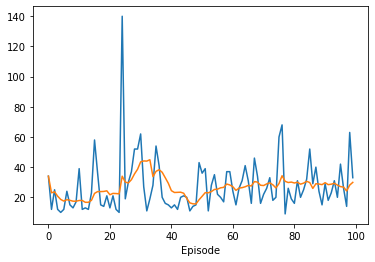

: 

In [8]:

# Generate the gym of Cart-and-Pole
env = gym.make( 'CartPole-v1' )

# The number of states and actions are +4 and +2
ns  = env.observation_space.shape[ 0 ]
na  = env.action_space.n


policy_net = PolicyNetwork( ns, na, 128 ) 

max_episode_num = 100
max_steps       = 1000
numsteps        = []
avg_numsteps    = []
all_rewards     = []

for episode in range( max_episode_num ):

    state     = env.reset()
    log_probs = []
    rewards   = []

    # Run a single trial
    for steps in range( max_steps ):
        env.render( )

        # Get the 
        action, log_prob = policy_net.get_action( state )
        new_state, reward, done, _ = env.step( action )

        log_probs.append( log_prob )
        rewards.append( reward )

        # If single trial conducted
        if done: 
            update_policy( policy_net, rewards, log_probs )
            numsteps.append(steps)
            avg_numsteps.append( np.mean( numsteps[ -10: ] ) )
            all_rewards.append( np.sum( rewards ))
            if episode % 1 == 0:
                sys.stdout.write( "episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break
        
        state = new_state
    

plt.plot( numsteps )
plt.plot( avg_numsteps )
plt.xlabel('Episode')
plt.show()